Number of rows before drop: 119
Number of rows after drop: 119
Number of columns in the dataframe: 113
Window = 0,6


/home/aleksander.kolodziej@A4BEE.ad/Desktop/EKG_PPG_BP/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


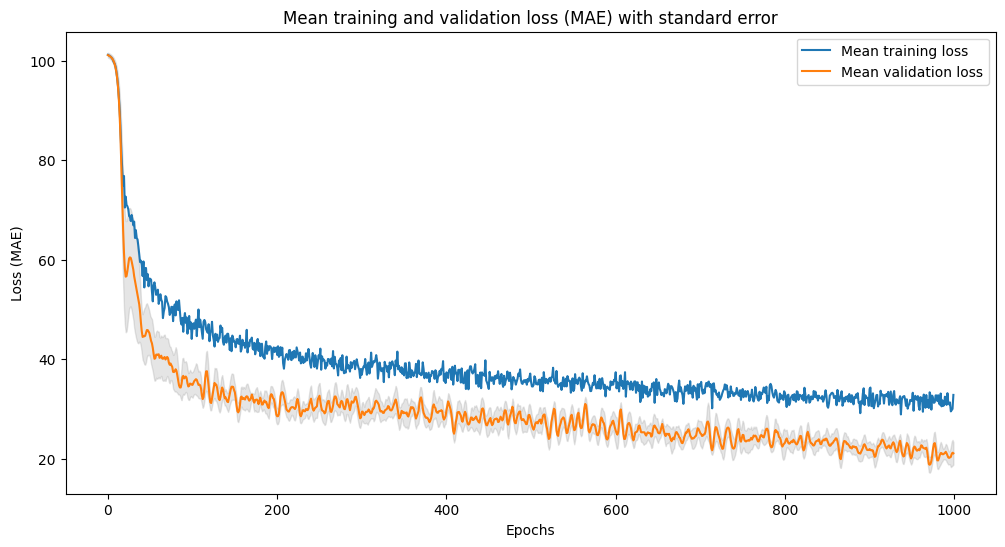

MAE for each fold:
Fold 1: MAE = 15.433
Fold 2: MAE = 23.625
Fold 3: MAE = 17.329
Fold 4: MAE = 19.322
Fold 5: MAE = 29.647

Average MAE: 21.071
Standard Deviation of MAE: 5.078


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('data_to_model.csv')
df = df.drop(columns=["Filename", "Unnamed: 0"])
print(f"Number of rows before drop: {df.shape[0]}")
df = df.dropna()
print(f"Number of rows after drop: {df.shape[0]}")
# Verify the number of columns
print(f"Number of columns in the dataframe: {df.shape[1]}")

if df.shape[1] == 113:
    print("Window = 0,6")
elif df.shape[1] == 187:
    print("Window = 1")
elif df.shape[1] == 372:
    print("Window = 2")

# Features and target separation
X = df.iloc[:, :-2].values  # First 740 columns as features
y = df.iloc[:, -2:].values  # Last 2 columns as targets

input_size = int(X.shape[1])

scaler = StandardScaler()
X = scaler.fit_transform(X)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def create_advanced_model(input_dim):
    # Define a Sequential model
    model = Sequential()
    
    # Add layers to the model
    model.add(Dense(input_dim, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(int(input_dim/2), activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(int(input_dim/2), activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(int(input_dim/4), activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(int(input_dim/8), activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(int(input_dim/16), activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(2, activation='linear'))  # Output layer with 2 neurons for regression
    
    # Compile the model with optimizer, loss function, and metrics
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    
    return model

# Initialize variables to store results
train_losses = []
val_losses = []

# List to store MAE scores for each fold
mae_scores = []

for fold_num, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = create_advanced_model(input_size)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=1000, batch_size=32, verbose=0, validation_data=(X_test, y_test))
    
    # Evaluate the model
    mae = model.evaluate(X_test, y_test, verbose=0)
    mae_scores.append(mae[0])  # Use the loss value which is MAE

    # Append losses to lists
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

# Calculate mean and standard error for losses for each epoch
mean_train_loss = np.mean(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)

std_val_loss = np.std(val_losses, axis=0)

se_val_loss = std_val_loss / np.sqrt(kf.get_n_splits())

# Plot mean losses with standard error for validation loss
plt.figure(figsize=(12, 6))
plt.plot(mean_train_loss, label='Mean training loss')
plt.plot(mean_val_loss, label='Mean validation loss')
plt.fill_between(range(len(mean_val_loss)), mean_val_loss - se_val_loss, mean_val_loss + se_val_loss, color='gray', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.title('Mean training and validation loss (MAE) with standard error')
plt.show()

# Calculate and display mean MAE and standard deviation of MAE
mean_mae = np.mean(mae_scores)
std_mae = np.std(mae_scores)

print("MAE for each fold:")
for fold_num, mae in enumerate(mae_scores, 1):
    print(f"Fold {fold_num}: MAE = {mae:.3f}")

print(f"\nAverage MAE: {mean_mae:.3f}")
print(f"Standard Deviation of MAE: {std_mae:.3f}")

# # Standard deviation for each fold
# print("\nStandard deviation of MAE for each fold:")
# for fold_num in range(1, kf.get_n_splits() + 1):
#     fold_std_mae = np.std([mae_scores[i] for i in range(kf.get_n_splits()) if i != fold_num - 1])
#     print(f"Fold {fold_num}: Standard Deviation of MAE = {fold_std_mae:.3f}")
